In [1]:
import pandas as pd
import mysql.connector
from mysql.connector import Error

# 1. Load the CSV file into a pandas dataframe
csv_file_path = 'CWC2023.csv'
df = pd.read_csv(csv_file_path)
# df.head()
# df = df.applymap(lambda x: str(x).replace(',','.') if isinstance(x, float) else x)

# df = df.apply(pd.to_numeric, errors="ignore")
# 2. Convert 'match_date' column to 'YYYY-MM-DD' format with error handling
# This will convert invalid dates to NaT (Not a Time) and allow us to deal with them.
df['Match Date'] = pd.to_datetime(df['Match Date'], format='%d-%m-%Y', errors='coerce')

# Optionally, print out rows where the conversion failed to identify problematic dates
invalid_dates = df[df['Match Date'].isna()]
if not invalid_dates.empty:
    print("Invalid dates found in the following rows:")
    print(invalid_dates)

# 3. Drop rows with invalid dates (if any), or you can choose to handle them differently
df.dropna(subset=['Match Date'], inplace=True)

# Ensure that date and time columns are properly formatted
df['Match Date'] = pd.to_datetime(df['Match Date'], format='%d-%m-%Y', errors='coerce').dt.date
df['Match Time'] = pd.to_datetime(df['Match Time'], format='%I:%M %p', errors='coerce').dt.time

# Handle invalid date/time by replacing NaT with None (which will be treated as NULL in MySQL)
df['Match Date'] = df['Match Date'].where(df['Match Date'].notna(), None)
df['Match Time'] = df['Match Time'].where(df['Match Time'].notna(), None)


df.head(20)

Invalid dates found in the following rows:
    Match ID Match Date Match Time     City       Stadium      Team A  \
30        31        NaT   02:00 PM  Kolkata  Eden Gardens  Bangladesh   

      Team B Toss Winner Toss Decision  Score A  ...  No Balls B  Penalty B  \
30  Pakistan  Bangladesh           Bat      205  ...           0          0   

    Extras B  Wining Team     Margin  Man of the Match               Umpire 1  \
30         9     Pakistan  7 Wickets      Fakhar Zaman  Richard Kettleborough   

       Umpire 2         TV Umpire  Match Refree  
30  Nitin Menon  Adrian Holdstock  Andy Pycroft  

[1 rows x 44 columns]


,Match ID,Match Date,Match Time,City,Stadium,Team A,Team B,Toss Winner,Toss Decision,Score A,...,No Balls B,Penalty B,Extras B,Wining Team,Margin,Man of the Match,Umpire 1,Umpire 2,TV Umpire,Match Refree
0,1,2023-10-05,14:00:00,Ahmedabad,Narendra Modi Stadium,England,NewZealand,NewZealand,Field,282,...,0,0,6,NewZealand,9 Wickets,Rachin Ravindra,Kumar Dharmasena,Nitin Menon,Paul Wilson,Javagal Srinath
1,2,2023-10-06,14:00:00,Hyderabad,Eden Gardens,Pakistan,Netherlands,Netherlands,Field,286,...,1,0,9,Pakistan,81 Runs,Saud Shakeel,Adrian Holdstock,Chris Brown,Rod Tucker,Jeff Crowe
2,3,2023-10-07,14:00:00,Dharamshala,HPCA Stadium,Afghanistan,Bangladesh,Bangladesh,Field,156,...,0,0,8,Bangladesh,6 Wickets,Mehidy Hasan Miraz,Joel Wilson,Kumar Dharmasena,Ahsan Raza,Andy Pycroft
3,4,2023-10-07,14:00:00,Delhi,Arun Jaitley Stadium,South Africa,Sri Lanka,Sri Lanka,Field,428,...,1,0,23,South Africa,102 Runs,Aiden Markram,Richard Illingworth,Sharfuddoula,Michael Gough,Javagal Srinath
4,5,2023-10-08,14:00:00,Chennai,M. A. Chidambaram Stadium,Australia,India,Australia,Bat,199,...,0,0,12,India,6 wickets,KL Rahul,Chris Gaffaney,Richard Kettleborough,Chris Brown,Richie Richardson
5,6,2023-10-09,14:00:00,Hyderabad,Rajiv Gandhi International Stadium,NewZealand,Netherlands,Netherlands,Field,322,...,2,0,13,NewZealand,99 Runs,Mitchell Santner,Paul Reiffel,Rod Tucker,Joel Wilson,Andy Pycroft
6,7,2023-10-10,10:30:00,Dharamshala,HPCA Stadium,England,Bangladesh,Bangladesh,Field,364,...,0,0,7,England,137 Runs,Dawid Malan,Ahsan Raza,Paul Wilson,Adrian Holdstock,Javagal Srinath
7,8,2023-10-10,14:00:00,Hyderabad,Rajiv Gandhi International Stadium,Sri Lanka,Pakistan,Sri Lanka,Bat,344,...,1,0,14,Pakistan,6 Wickets,Mohammad Rizwan,Chris Gaffaney,Alex Wharf,Nitin Menon,Andy Pycroft
8,9,2023-10-11,14:00:00,Delhi,Arun Jaitley Stadium,Afghanistan,India,Afghanistan,Bat,272,...,2,0,15,India,8 Wickets,Rohit Sharma,Michael Gough,Paul Reiffel,Marais Erasmus,Jeff Crowe
9,10,2023-10-12,14:00:00,Lucknow,BRSABV Ekana Cricket Stadium,South Africa,Australia,Australia,Field,311,...,0,0,13,South Africa,134 Runs,Quinton de Kock,Joel Wilson,Richard Illingworth,Richard Kettleborough,Javagal Srinath


In [3]:
df.columns

Index(['Match ID', 'Match Date', 'Match Time', 'City', 'Stadium', 'Team A',
       'Team B', 'Toss Winner', 'Toss Decision', 'Score A', 'Wickets A',
       'Overs Played A', 'Maiden Overs A', '4s A', '6s A', 'Boundaries A',
       'Runrate A', 'Leg Byes A', 'Byes A', 'Wides A', 'No Balls A',
       'Penalty A', 'Extras A', 'Score B', 'Wickets B', 'Overs Played B',
       'Maiden Overs B', '4s B', '6s B', 'Boundaries B', 'Runrate B',
       'Leg Byes B', 'Byes B', 'Wides B', 'No Balls B', 'Penalty B',
       'Extras B', 'Wining Team', 'Margin', 'Man of the Match', 'Umpire 1',
       'Umpire 2', 'TV Umpire', 'Match Refree'],
      dtype='object')

In [ ]:
df.dtypes

In [ ]:
df.isnull().sum()
df.dropna(inplace= True)
df.isnull().sum()

In [ ]:

# 4. Convert 'Runrate A' and 'Runrate B' columns to numeric, replacing commas with dots (if necessary)
df['Runrate A'] = df['Runrate A'].str.replace(',', '.').astype(float)
df['Runrate B'] = df['Runrate B'].str.replace(',', '.').astype(float)
df

In [ ]:
for i, row in df.iterrows():
    
    print(i,row)
 

In [2]:
# 2. Establish connection to MySQL (use your actual credentials)
try:
    connection = mysql.connector.connect(
        host='localhost',  # Change to your MySQL host
        user='root',       # Change to your MySQL username
        password='Azsxdcf123@',  # Change to your MySQL password
    )
    
    if connection.is_connected():
        print("Connected to MySQL")

        # 3. Create a new database if it does not exist
        cursor = connection.cursor()
        cursor.execute("CREATE DATABASE IF NOT EXISTS cricket_data")
        cursor.execute("USE cricket_data")

        # 4. Create a table if it does not exist
        create_table_query = """
        CREATE TABLE IF NOT EXISTS match_stats (
            match_id INT PRIMARY KEY,
            match_date DATE,
            match_time TIME,
            city VARCHAR(100),
            stadium VARCHAR(100),
            team_a VARCHAR(50),
            team_b VARCHAR(50),
            toss_winner VARCHAR(50),
            toss_decision VARCHAR(50),
            score_a INT,
            wickets_a INT,
            overs_played_a DECIMAL(4,1),
            maiden_overs_a INT,
            fours_a INT,
            sixes_a INT,
            boundaries_a INT,
            runrate_a DECIMAL(10,2),
            leg_byes_a INT,
            byes_a INT,
            wides_a INT,
            no_balls_a INT,
            penalty_a INT,
            extras_a INT,
            score_b INT,
            wickets_b INT,
            overs_played_b DECIMAL(20,1),
            maiden_overs_b INT,
            fours_b INT,
            sixes_b INT,
            boundaries_b INT,
            runrate_b DECIMAL(10,2),
            leg_byes_b INT,
            byes_b INT,
            wides_b INT,
            no_balls_b INT,
            penalty_b INT,
            extras_b INT,
            winning_team VARCHAR(50),
            margin VARCHAR(50),
            man_of_the_match VARCHAR(100),
            umpire_1 VARCHAR(100),
            umpire_2 VARCHAR(100),
            tv_umpire VARCHAR(100),
            match_referee VARCHAR(100)
        );
        """
        cursor.execute(create_table_query)

        # 5. Insert data into the table
        for i, row in df.iterrows():
            insert_query = """
            INSERT INTO match_stats (
                match_id, match_date, match_time, city, stadium, team_a, team_b, toss_winner, toss_decision,
                score_a, wickets_a, overs_played_a, maiden_overs_a, fours_a, sixes_a, boundaries_a, runrate_a,
                leg_byes_a, byes_a, wides_a, no_balls_a, penalty_a, extras_a, score_b, wickets_b, overs_played_b,
                maiden_overs_b, fours_b, sixes_b, boundaries_b, runrate_b, leg_byes_b, byes_b, wides_b, no_balls_b,
                penalty_b, extras_b, winning_team, margin, man_of_the_match, umpire_1, umpire_2, tv_umpire, match_referee
            ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,
                      %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
            """
            
            cursor.execute(insert_query, tuple(row))
        
        connection.commit()
        print("Data inserted successfully!")

except Error as e:
    print(f"Error: {e}")
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection closed")


Connected to MySQL
Data inserted successfully!
MySQL connection closed


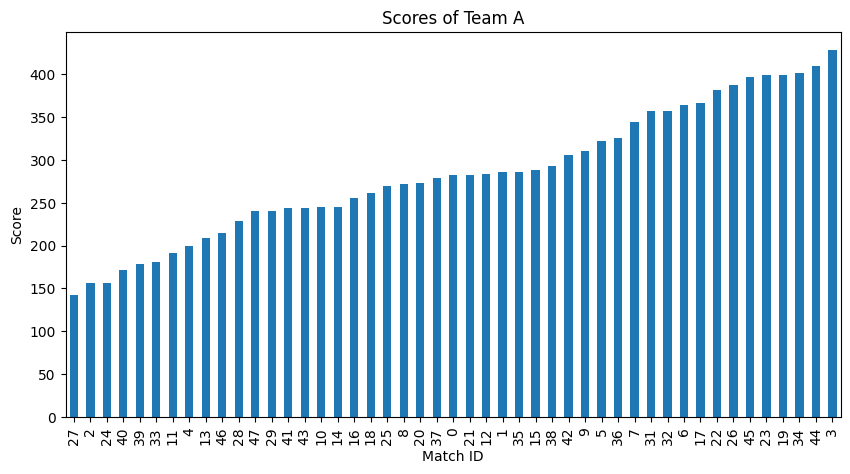

In [2]:

# Optionally, if you want to visualize or analyze the data further using pandas or matplotlib:
import matplotlib.pyplot as plt

# Example: Plot a simple chart of match scores
plt.figure(figsize=(10,5))
df['Score A'].sort_values().plot(kind='bar', title="Scores of Team A")
plt.xlabel('Match ID')
plt.ylabel('Score')
plt.show()


In [8]:
df.head()

,Match ID,Match Date,Match Time,City,Stadium,Team A,Team B,Toss Winner,Toss Decision,Score A,...,No Balls B,Penalty B,Extras B,Wining Team,Margin,Man of the Match,Umpire 1,Umpire 2,TV Umpire,Match Refree
0,1,2023-10-05,14:00:00,Ahmedabad,Narendra Modi Stadium,England,NewZealand,NewZealand,Field,282,...,0,0,6,NewZealand,9 Wickets,Rachin Ravindra,Kumar Dharmasena,Nitin Menon,Paul Wilson,Javagal Srinath
1,2,2023-10-06,14:00:00,Hyderabad,Eden Gardens,Pakistan,Netherlands,Netherlands,Field,286,...,1,0,9,Pakistan,81 Runs,Saud Shakeel,Adrian Holdstock,Chris Brown,Rod Tucker,Jeff Crowe
2,3,2023-10-07,14:00:00,Dharamshala,HPCA Stadium,Afghanistan,Bangladesh,Bangladesh,Field,156,...,0,0,8,Bangladesh,6 Wickets,Mehidy Hasan Miraz,Joel Wilson,Kumar Dharmasena,Ahsan Raza,Andy Pycroft
3,4,2023-10-07,14:00:00,Delhi,Arun Jaitley Stadium,South Africa,Sri Lanka,Sri Lanka,Field,428,...,1,0,23,South Africa,102 Runs,Aiden Markram,Richard Illingworth,Sharfuddoula,Michael Gough,Javagal Srinath
4,5,2023-10-08,14:00:00,Chennai,M. A. Chidambaram Stadium,Australia,India,Australia,Bat,199,...,0,0,12,India,6 wickets,KL Rahul,Chris Gaffaney,Richard Kettleborough,Chris Brown,Richie Richardson


In [12]:
df.head()
df.value_counts(["Stadium"])

Stadium                                
Arun Jaitley Stadium                       5
BRSABV Ekana Cricket Stadium               5
Eden Gardens                               5
HPCA Stadium                               5
M. A. Chidambaram Stadium                  5
M. Chinnaswamy Stadium                     5
Maharashtra Cricket Association Stadium    5
Narendra Modi Stadium                      5
Wankhede Stadium                           5
Rajiv Gandhi International Stadium         2
Name: count, dtype: int64

In [18]:
df[["Stadium","City","Score A"]].sort_values(by="Score A")

,Stadium,City,Score A
27,Eden Gardens,Kolkata,142
2,HPCA Stadium,Dharamshala,156
24,M. Chinnaswamy Stadium,Bangalore,156
40,M. Chinnaswamy Stadium,Bangalore,171
39,Maharashtra Cricket Association Stadium,Pune,179
33,BRSABV Ekana Cricket Stadium,Lucknow,181
11,Narendra Modi Stadium,Ahmedabad,191
4,M. A. Chidambaram Stadium,Chennai,199
13,BRSABV Ekana Cricket Stadium,Lucknow,209
46,Eden Gardens,Kolkata,215


In [1]:
pip install sqlalchemy

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 2.1/2.1 MB 16.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import Table, MetaData, Column, Integer, String, Date, Time, DECIMAL

# Load CSV into DataFrame
csv_file_path = 'your_csv_file.csv'  # Adjust this path to the correct location of your CSV
columns = [
    'Match ID', 'Match Date', 'Match Time', 'City', 'Stadium', 'Team A', 'Team B', 'Toss Winner', 'Toss Decision', 
    'Score A', 'Wickets A', 'Overs Played A', 'Maiden Overs A', '4s A', '6s A', 'Boundaries A', 'Runrate A', 
    'Leg Byes A', 'Byes A', 'Wides A', 'No Balls A', 'Penalty A', 'Extras A', 'Score B', 'Wickets B', 'Overs Played B', 
    'Maiden Overs B', '4s B', '6s B', 'Boundaries B', 'Runrate B', 'Leg Byes B', 'Byes B', 'Wides B', 'No Balls B', 
    'Penalty B', 'Extras B', 'Wining Team', 'Margin', 'Man of the Match', 'Umpire 1', 'Umpire 2', 'TV Umpire', 'Match Refree'
]
df = pd.read_csv(csv_file_path, names=columns, header=0)

# Ensure correct data types and formats for 'Match Date' and 'Match Time'
df['Match Date'] = pd.to_datetime(df['Match Date'], format='%d-%m-%Y', errors='coerce').dt.date
df['Match Time'] = pd.to_datetime(df['Match Time'], format='%I:%M %p', errors='coerce').dt.time

# Replace commas with periods for decimal values (e.g., 'Runrate A' and 'Runrate B')
df['Runrate A'] = pd.to_numeric(df['Runrate A'].str.replace(',', '.'), errors='coerce')
df['Runrate B'] = pd.to_numeric(df['Runrate B'].str.replace(',', '.'), errors='coerce')

# Handle invalid dates and times
df['Match Date'] = df['Match Date'].where(df['Match Date'].notna(), None)
df['Match Time'] = df['Match Time'].where(df['Match Time'].notna(), None)

# Define the connection string
# Replace with your actual credentials
username = 'root'
password = 'Azsxdcf123@'
database = 'cricket_data'
host = 'localhost'  # Or your MySQL host, e.g., '127.0.0.1'

# Create SQLAlchemy engine for MySQL
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}/{database}')

# Create a connection to the database
connection = engine.connect()

# Create table schema (using SQLAlchemy)
metadata = MetaData()

match_stats_table = Table('match_stats', metadata,
    Column('match_id', Integer, primary_key=True),
    Column('match_date', Date),
    Column('match_time', Time),
    Column('city', String(100)),
    Column('stadium', String(100)),
    Column('team_a', String(50)),
    Column('team_b', String(50)),
    Column('toss_winner', String(50)),
    Column('toss_decision', String(50)),
    Column('score_a', Integer),
    Column('wickets_a', Integer),
    Column('overs_played_a', DECIMAL(4, 1)),
    Column('maiden_overs_a', Integer),
    Column('fours_a', Integer),
    Column('sixes_a', Integer),
    Column('boundaries_a', Integer),
    Column('runrate_a', DECIMAL(5, 2)),
    Column('leg_byes_a', Integer),
    Column('byes_a', Integer),
    Column('wides_a', Integer),
    Column('no_balls_a', Integer),
    Column('penalty_a', Integer),
    Column('extras_a', Integer),
    Column('score_b', Integer),
    Column('wickets_b', Integer),
    Column('overs_played_b', DECIMAL(4, 1)),
    Column('maiden_overs_b', Integer),
    Column('fours_b', Integer),
    Column('sixes_b', Integer),
    Column('boundaries_b', Integer),
    Column('runrate_b', DECIMAL(5, 2)),
    Column('leg_byes_b', Integer),
    Column('byes_b', Integer),
    Column('wides_b', Integer),
    Column('no_balls_b', Integer),
    Column('penalty_b', Integer),
    Column('extras_b', Integer),
    Column('winning_team', String(50)),
    Column('margin', String(50)),
    Column('man_of_the_match', String(100)),
    Column('umpire_1', String(100)),
    Column('umpire_2', String(100)),
    Column('tv_umpire', String(100)),
    Column('match_referee', String(100))
)

# Create table if it doesn't exist
metadata.create_all(engine)

# Insert data into the table
df.to_sql('match_stats', con=engine, if_exists='append', index=False)

# Commit and close connection
connection.close()

print("Data inserted successfully!")


FileNotFoundError: [Errno 2] No such file or directory: 'your_csv_file.csv'

In [9]:
import pandas as pd
import pymysql
from pymysql import MySQLError

# Define the column names exactly as you provided
columns = [
    'Match ID', 'Match Date', 'Match Time', 'City', 'Stadium', 'Team A', 'Team B', 'Toss Winner', 'Toss Decision', 
    'Score A', 'Wickets A', 'Overs Played A', 'Maiden Overs A', '4s A', '6s A', 'Boundaries A', 'Runrate A', 
    'Leg Byes A', 'Byes A', 'Wides A', 'No Balls A', 'Penalty A', 'Extras A', 'Score B', 'Wickets B', 'Overs Played B', 
    'Maiden Overs B', '4s B', '6s B', 'Boundaries B', 'Runrate B', 'Leg Byes B', 'Byes B', 'Wides B', 'No Balls B', 
    'Penalty B', 'Extras B', 'Wining Team', 'Margin', 'Man of the Match', 'Umpire 1', 'Umpire 2', 'TV Umpire', 'Match Refree'
]

# Load CSV into DataFrame
csv_file_path = 'CWC2023.csv'  # Adjust this path to the correct location of your CSV
df = pd.read_csv(csv_file_path, names=columns, header=0)

# Ensure that date and time columns are properly formatted
df['Match Date'] = pd.to_datetime(df['Match Date'], format='%d-%m-%Y', errors='coerce').dt.date
df['Match Time'] = pd.to_datetime(df['Match Time'], format='%I:%M %p', errors='coerce').dt.time

# Handle invalid date/time by replacing NaT with None (which will be treated as NULL in MySQL)
df['Match Date'] = df['Match Date'].where(df['Match Date'].notna(), None)
df['Match Time'] = df['Match Time'].where(df['Match Time'].notna(), None)


# Establish connection to MySQL using pymysql
try:
    connection = pymysql.connect(
        host='localhost',  # Change to your MySQL host
        user='root',       # Change to your MySQL username
        password='Azsxdcf123@',  # Change to your MySQL password
        database='cricket_data'  # Use the specific database (can also be created first if needed)
    )

    with connection.cursor() as cursor:
        print("Connected to MySQL")

        # Create table if not exists
        create_table_query = """
        CREATE TABLE IF NOT EXISTS match_stats (
            match_id INT PRIMARY KEY,
            match_date DATE,
            match_time TIME,
            city VARCHAR(100),
            stadium VARCHAR(100),
            team_a VARCHAR(50),
            team_b VARCHAR(50),
            toss_winner VARCHAR(50),
            toss_decision VARCHAR(50),
            score_a INT,
            wickets_a INT,
            overs_played_a DECIMAL(4,1),
            maiden_overs_a INT,
            fours_a INT,
            sixes_a INT,
            boundaries_a INT,
            runrate_a DECIMAL(5,2),
            leg_byes_a INT,
            byes_a INT,
            wides_a INT,
            no_balls_a INT,
            penalty_a INT,
            extras_a INT,
            score_b INT,
            wickets_b INT,
            overs_played_b DECIMAL(4,1),
            maiden_overs_b INT,
            fours_b INT,
            sixes_b INT,
            boundaries_b INT,
            runrate_b DECIMAL(5,2),
            leg_byes_b INT,
            byes_b INT,
            wides_b INT,
            no_balls_b INT,
            penalty_b INT,
            extras_b INT,
            winning_team VARCHAR(50),
            margin VARCHAR(50),
            man_of_the_match VARCHAR(100),
            umpire_1 VARCHAR(100),
            umpire_2 VARCHAR(100),
            tv_umpire VARCHAR(100),
            match_referee VARCHAR(100)
        );
        """
        cursor.execute(create_table_query)

        # Insert data into the table
        for i, row in df.iterrows():
            # Ensure match_date and match_time are correctly formatted as strings for SQL
            match_date = row['Match Date'] if pd.notna(row['Match Date']) else None  # Handle NaT
            match_time = row['Match Time'] if pd.notna(row['Match Time']) else None  # Handle NaT

            insert_query = """
            INSERT INTO match_stats (
                match_id, match_date, match_time, city, stadium, team_a, team_b, toss_winner, toss_decision,
                score_a, wickets_a, overs_played_a, maiden_overs_a, fours_a, sixes_a, boundaries_a, runrate_a,
                leg_byes_a, byes_a, wides_a, no_balls_a, penalty_a, extras_a, score_b, wickets_b, overs_played_b,
                maiden_overs_b, fours_b, sixes_b, boundaries_b, runrate_b, leg_byes_b, byes_b, wides_b, no_balls_b,
                penalty_b, extras_b, winning_team, margin, man_of_the_match, umpire_1, umpire_2, tv_umpire, match_referee
            ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,
                      %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
            """
            cursor.execute(insert_query, tuple(row))

        connection.commit()
        print("Data inserted successfully!")

except MySQLError as e:
    print(f"Error: {e}")
finally:
    if connection.open:
        connection.close()
        print("MySQL connection closed")


Connected to MySQL
Error: (1366, "Incorrect decimal value: '5,20' for column 'runrate_b' at row 1")
MySQL connection closed


In [7]:
pip install  pymysql


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
